In [1]:
import _pickle as cPickle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
import pandas as pd
import copy
import statistics
import math
from sklearn import metrics

with open(r"../graphs/graph_fixed_attr.pickle", "rb") as input_file:
    G = cPickle.load(input_file).to_undirected()

In [7]:
def calculate_weighted_global_efficiency(G):
    """
    Calculate the global efficiency of a graph considering edge weights.

    Parameters:
        G (networkx.Graph): The graph.

    Returns:
        float: The global efficiency.
    """
    # Calculate the shortest path lengths considering edge weights
    shortest_paths = nx.all_pairs_dijkstra_path_length(G, weight='KM')

    # Initialize variables for calculating global efficiency
    total_efficiency = 0
    total_pairs = 0

    # Iterate over pairs of nodes and their shortest path lengths
    for source, target_lengths in shortest_paths:
        for target, length in target_lengths.items():
            if length == 0:
                continue  # Skip nodes that are not connected
            total_efficiency += 1 / length
            total_pairs += 1

    # Calculate the global efficiency
    global_efficiency = total_efficiency / total_pairs

    return global_efficiency

def robustness(G2):
    result = {}
    # Targeted attack - G2
    lccs = []
    fractions = []
    for phi in range(0, 101, 5):
        fraction = phi / 100
        G_copy = copy.deepcopy(G2)
        nodes = list(G_copy.nodes())
        nodes.sort(key=lambda n: G_copy.nodes[n]['ridership'], reverse=True)
        nodes_to_remove = nodes[:int(fraction * len(nodes))]
        G_copy.remove_nodes_from(nodes_to_remove)
        try:
            lcc_size = max(len(c) for c in nx.connected_components(G_copy)) / len(G_copy)
            fractions.append(fraction)
            lccs.append(lcc_size)
        except:
            continue
    result['Lcc'] =  metrics.auc(fractions, lccs)


    # Targeted attack - G2
    lccs = []
    fractions = []
    for phi in range(0, 101, 5):
        fraction = phi / 100
        G_copy = copy.deepcopy(G2)
        nodes = list(G_copy.nodes())
        nodes.sort(key=lambda n: G_copy.nodes[n]['ridership'], reverse=True)
        nodes_to_remove = nodes[:int(fraction * len(nodes))]
        G_copy.remove_nodes_from(nodes_to_remove)
        try:
            lcc_size = nx.global_efficiency(G_copy)
            # lcc_size = calculate_weighted_global_efficiency(G_copy)
            fractions.append(fraction)
            lccs.append(lcc_size)
        except:
            continue
    result['Efficiency'] =  metrics.auc(fractions, lccs)
    return result


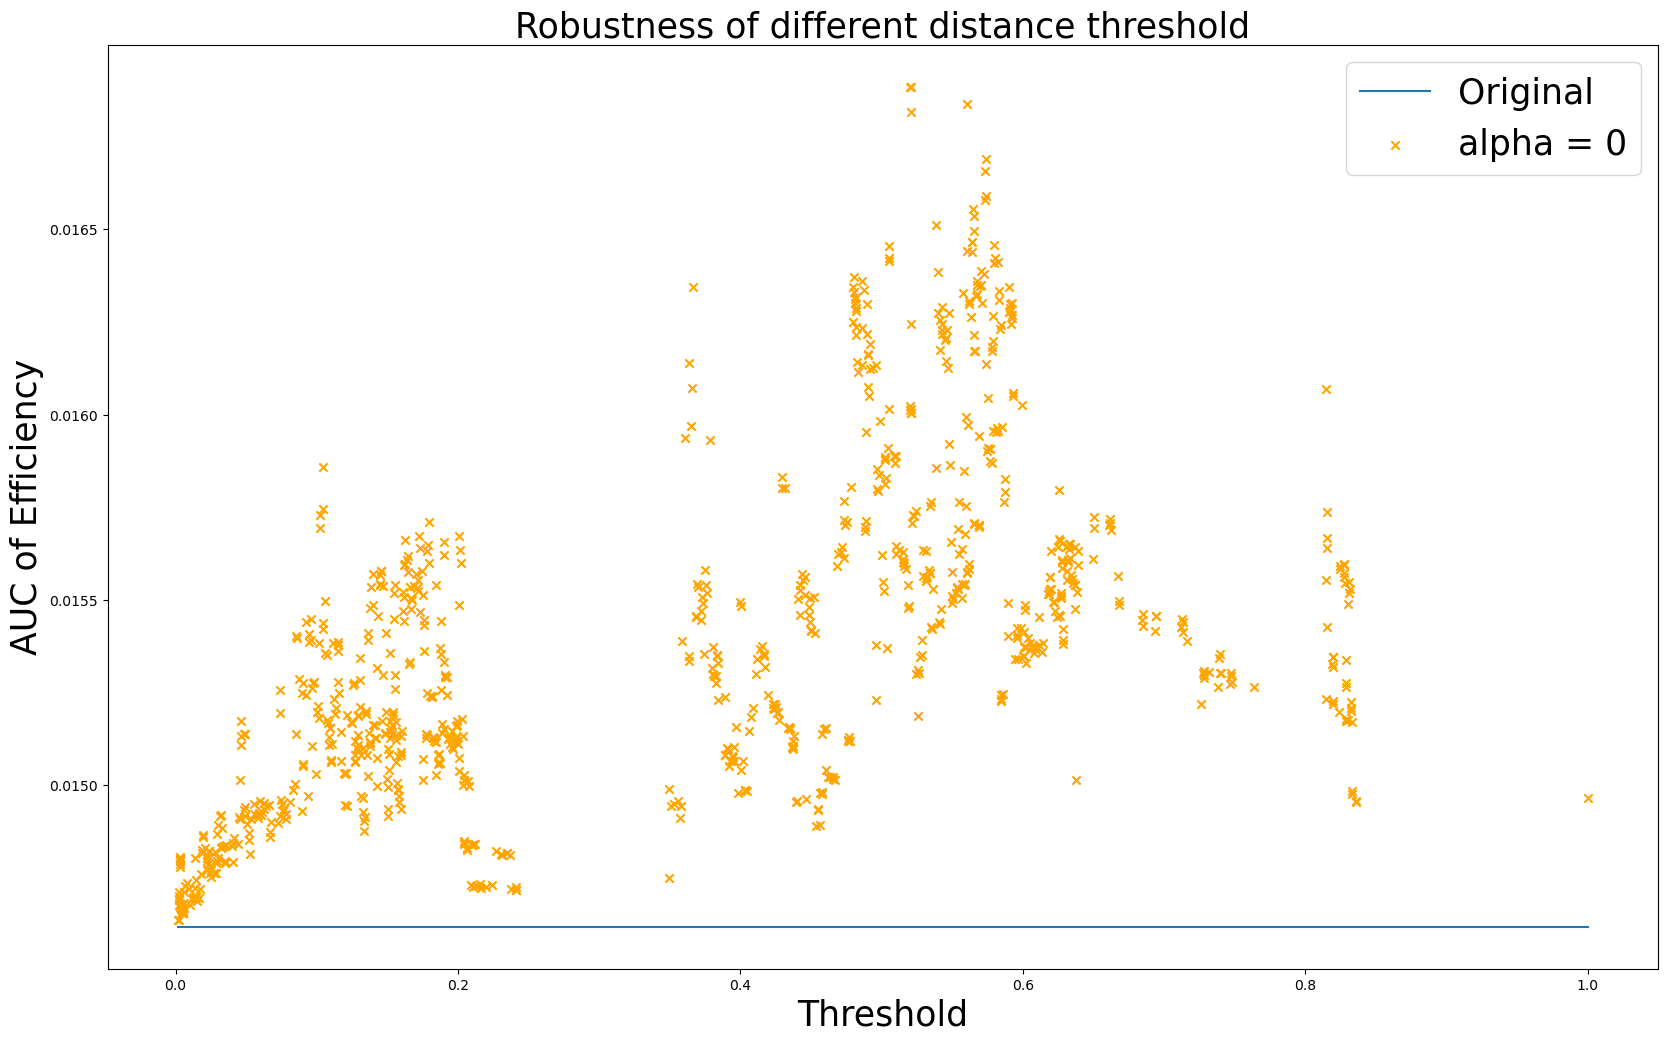

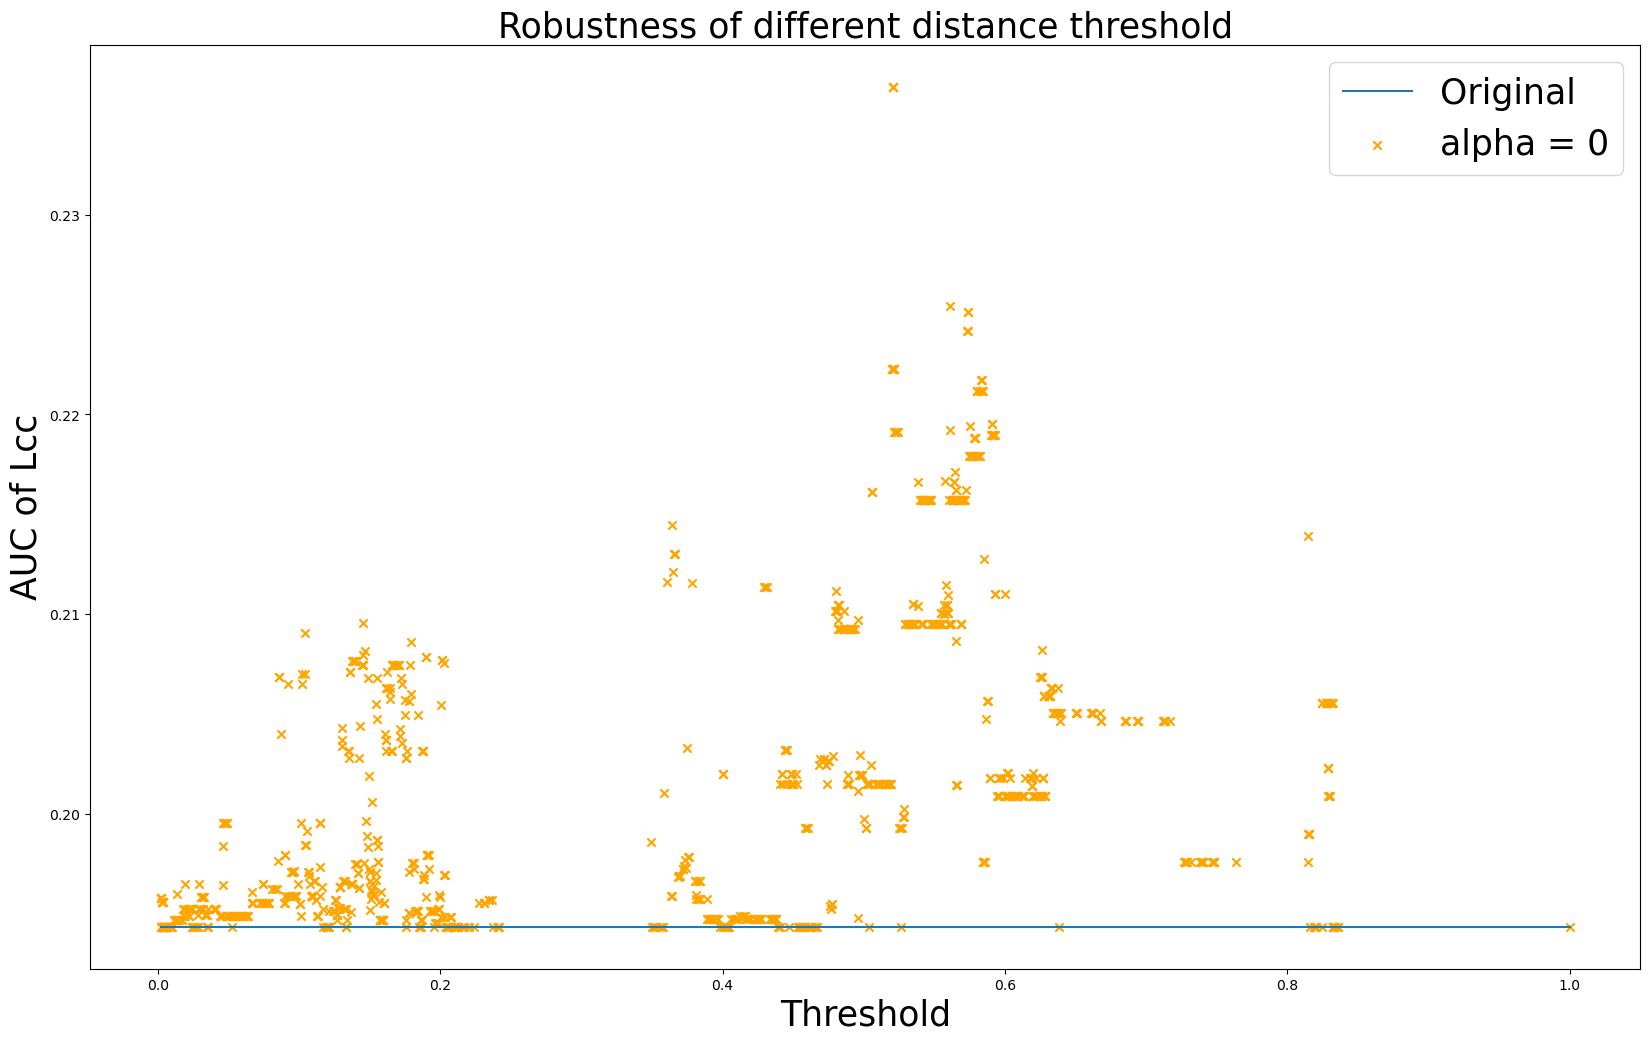

In [8]:
plt.figure(figsize=(20, 12))
with open(r"../files/iterations/ASP_5tracks_rider_0.pickle", "rb") as input_file:
    iterations0 = cPickle.load(input_file)
e = robustness(G)
es = [e['Efficiency'] for _ in range(len(iterations0['thresholds']))]
plt.plot(iterations0['thresholds'], es,  label = 'Original')
# plt.plot(iterations5['thresholds'], iterations5["efficiency_scores"], marker='x', label = 'alpha = 5')
# plt.plot(iterations1['thresholds'], iterations1["efficiency_scores"], marker='x', label = 'alpha = 1')
# plt.plot(iterations05['thresholds'], iterations05["efficiency_scores"], marker='x', label = 'alpha = 0.5')
plt.scatter(iterations0['thresholds'], iterations0["efficiency_scores"], marker='x', label = 'alpha = 0', color = 'orange')
plt.legend(loc = 'best',fontsize=25)
plt.xlabel('Threshold',fontsize=25)
plt.ylabel('AUC of Efficiency',fontsize=25)
plt.title('Robustness of different distance threshold',fontsize=25)
plt.savefig('../plots/robustness/efficiency_ASP_5tracks_rider_0.png')

plt.show()

plt.figure(figsize=(20, 12))

es = [e['Lcc'] for _ in range(len(iterations0['thresholds']))]
plt.plot(iterations0['thresholds'], es,  label = 'Original')
# plt.plot(iterations5['thresholds'], iterations5["lcc_scores"], marker='x', label = 'alpha = 5')
# plt.plot(iterations1['thresholds'], iterations1["lcc_scores"], marker='x', label = 'alpha = 1')
# plt.plot(iterations05['thresholds'], iterations05["lcc_scores"], marker='x', label = 'alpha = 0.5')
plt.scatter(iterations0['thresholds'], iterations0["lcc_scores"], marker='x', label = 'alpha = 0', color = 'orange')
plt.legend(loc = 'best',fontsize=25)
plt.xlabel('Threshold',fontsize=25)
plt.ylabel('AUC of Lcc',fontsize=25)
plt.title('Robustness of different distance threshold',fontsize=25)
plt.savefig('../plots/robustness/lcc_ASP_5tracks_rider_0.png')
plt.show()

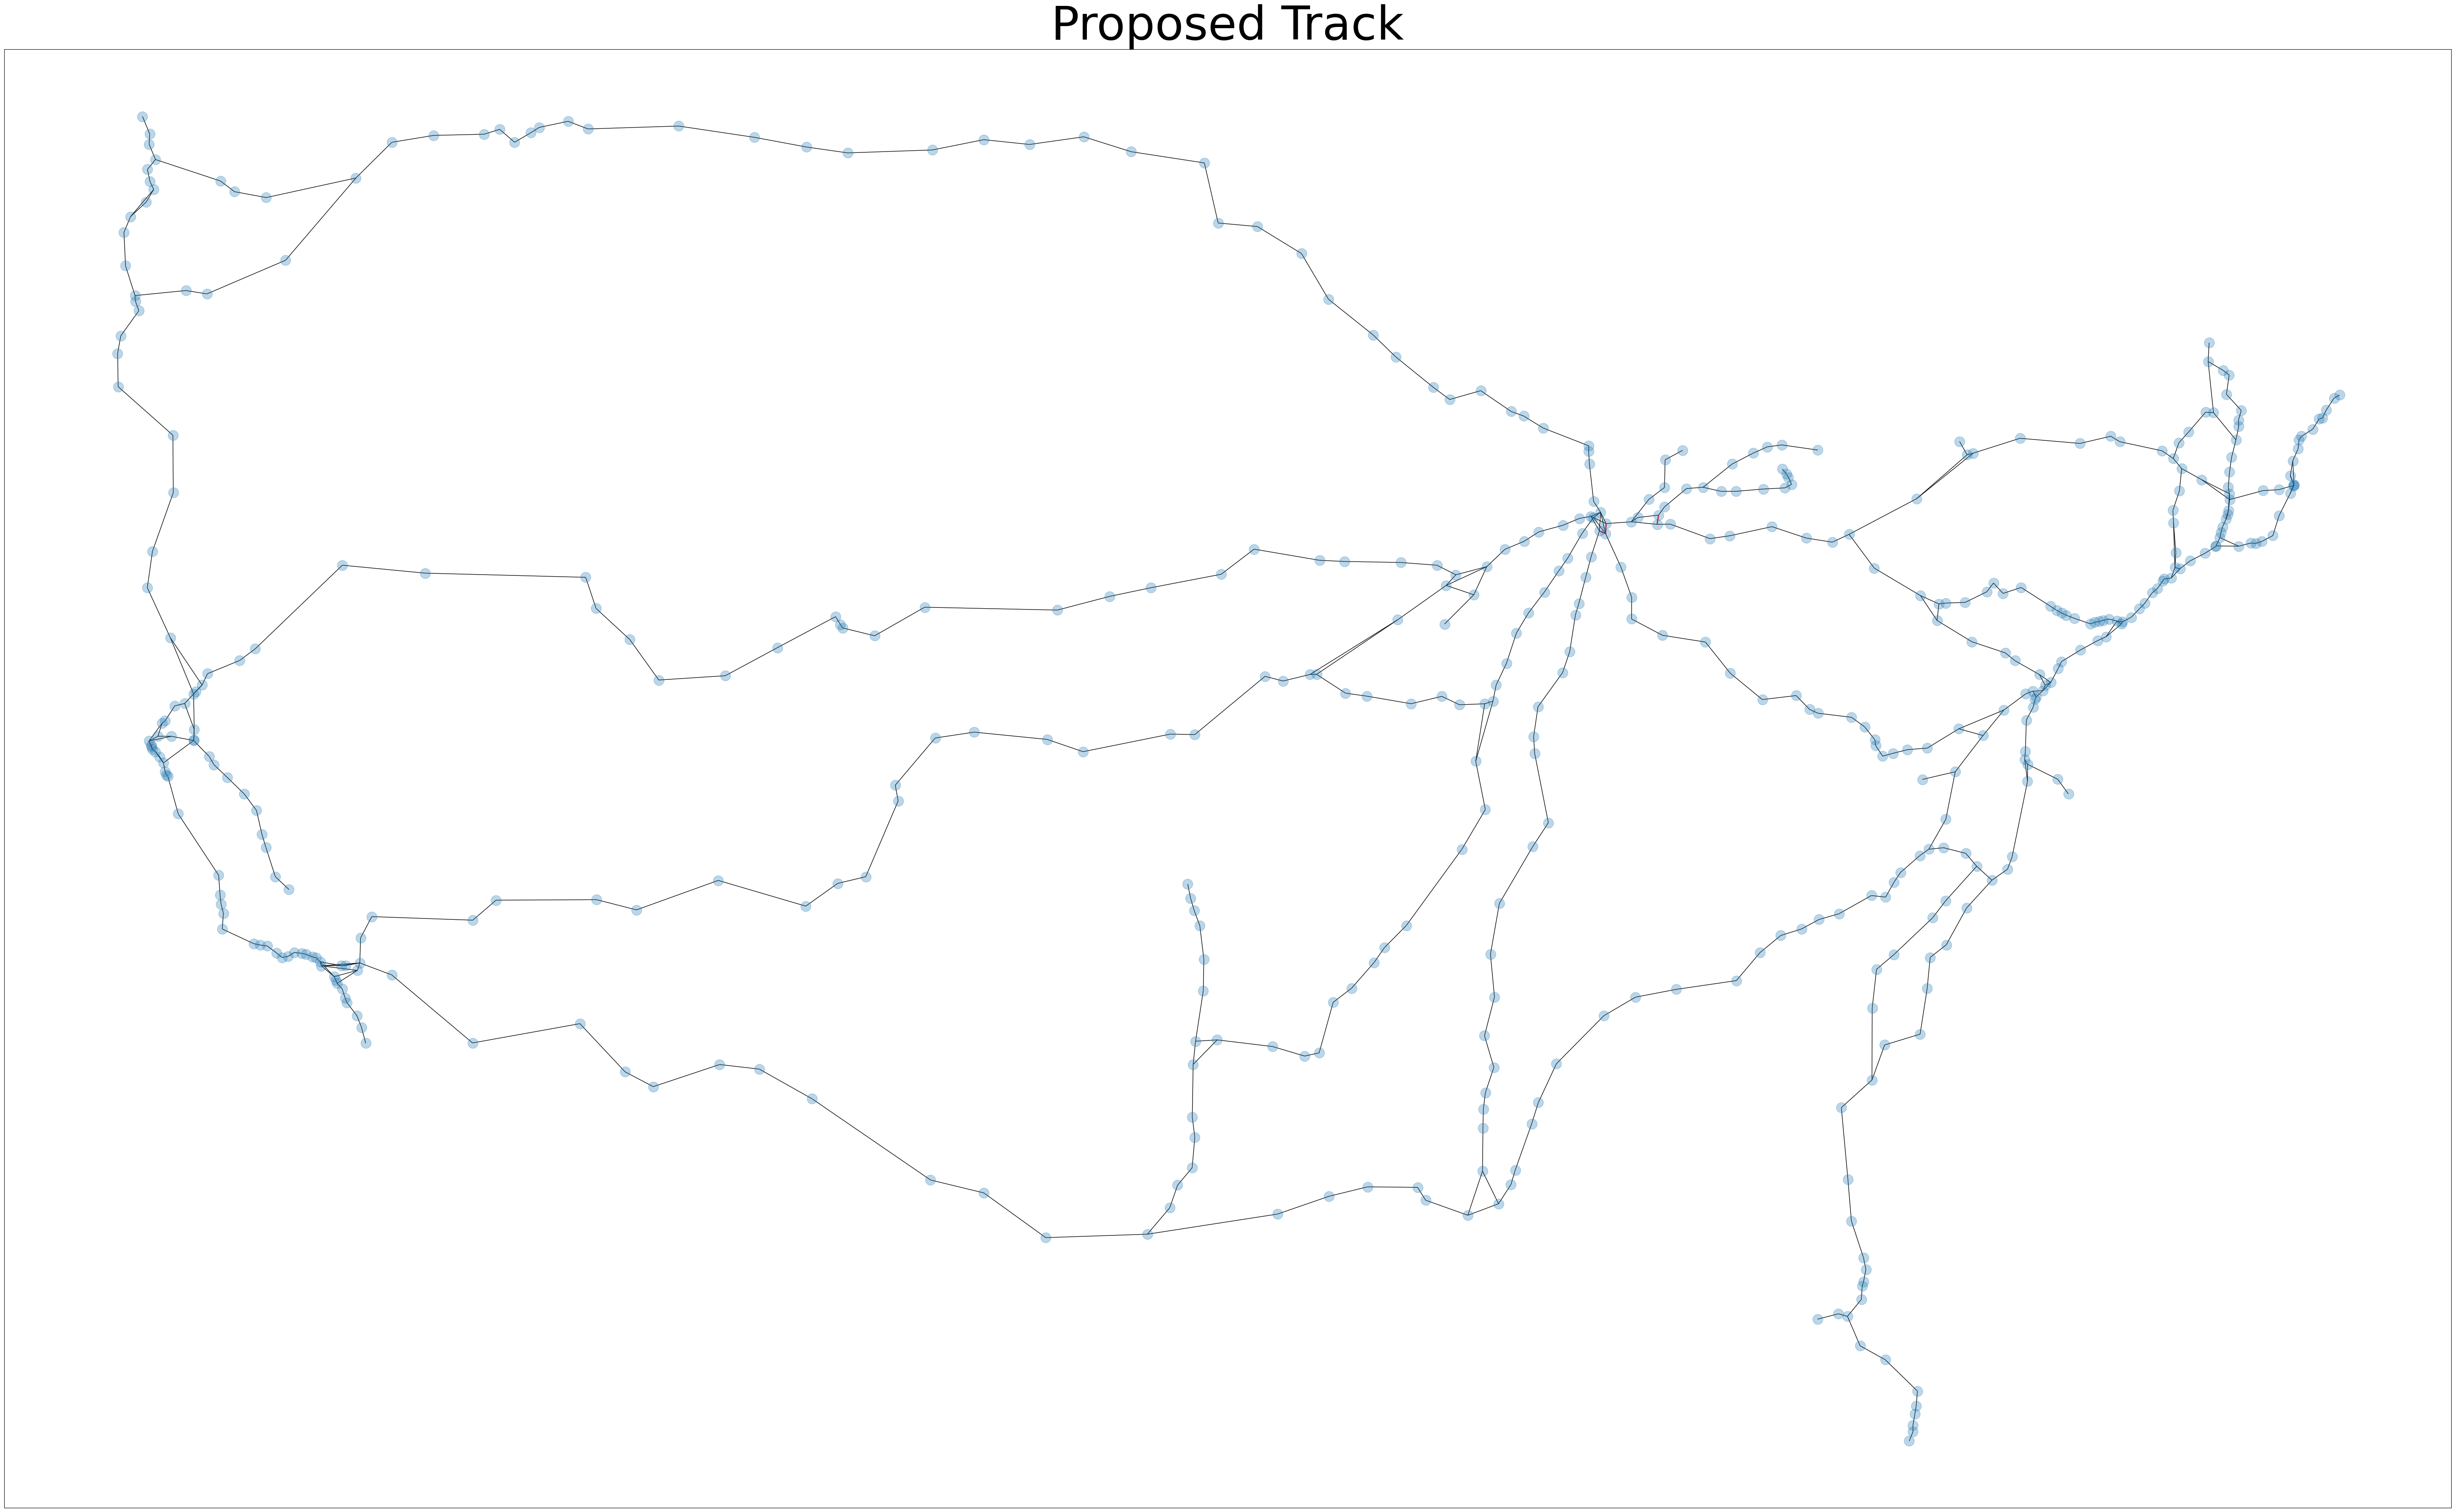

In [11]:
x = dict(nx.get_node_attributes(G, 'x'))
y = dict(nx.get_node_attributes(G, 'y'))

iter_df = pd.DataFrame(iterations0)

top_edges = iterations0['edges'][iter_df[iter_df['thresholds'] < 0.01]['efficiency_scores'].idxmax()]
G2 = copy.deepcopy(G)
G2.add_edges_from(top_edges)
# Define positions, edge labels, and node labels
pos = {}
KM = nx.get_edge_attributes(G2, 'KM')
name = nx.get_node_attributes(G2, 'name')
KM = {i: round(KM[i], 2) for i in KM}
for i in G2.nodes:
    pos[i] = (x[i], y[i])
labels = {node: name[node] for node in G2.nodes}

# Draw the network with different edge colors
plt.figure(figsize=(75, 45))
for edge in G2.edges():
    if (edge[0], edge[1]) in top_edges or (edge[1], edge[0]) in top_edges:  # Check if the edge is the one you added
        nx.draw_networkx_edges(G2, pos, edgelist=[edge], edge_color='red', width=2.0)  # Set color to red for the added edge
    else:
        nx.draw_networkx_edges(G2, pos, edgelist=[edge], width=1.0)  # Use default color for other edges
nx.draw_networkx_nodes(G2, pos, alpha=0.3)
# nx.draw_networkx_labels(G2, pos, labels, font_size=12, font_color='black')
title = 'Proposed Track'
plt.title(title, fontsize = 80)
plt.savefig('../plots/new_track/presentation/ASP_5tracks_rider_0_alpha0_threshold01.png')
plt.show()
with open(r"../graphs/ASP_5tracks_rider_0_alpha0_threshold01.pickle", "wb") as output_file:
    cPickle.dump(G2, output_file)

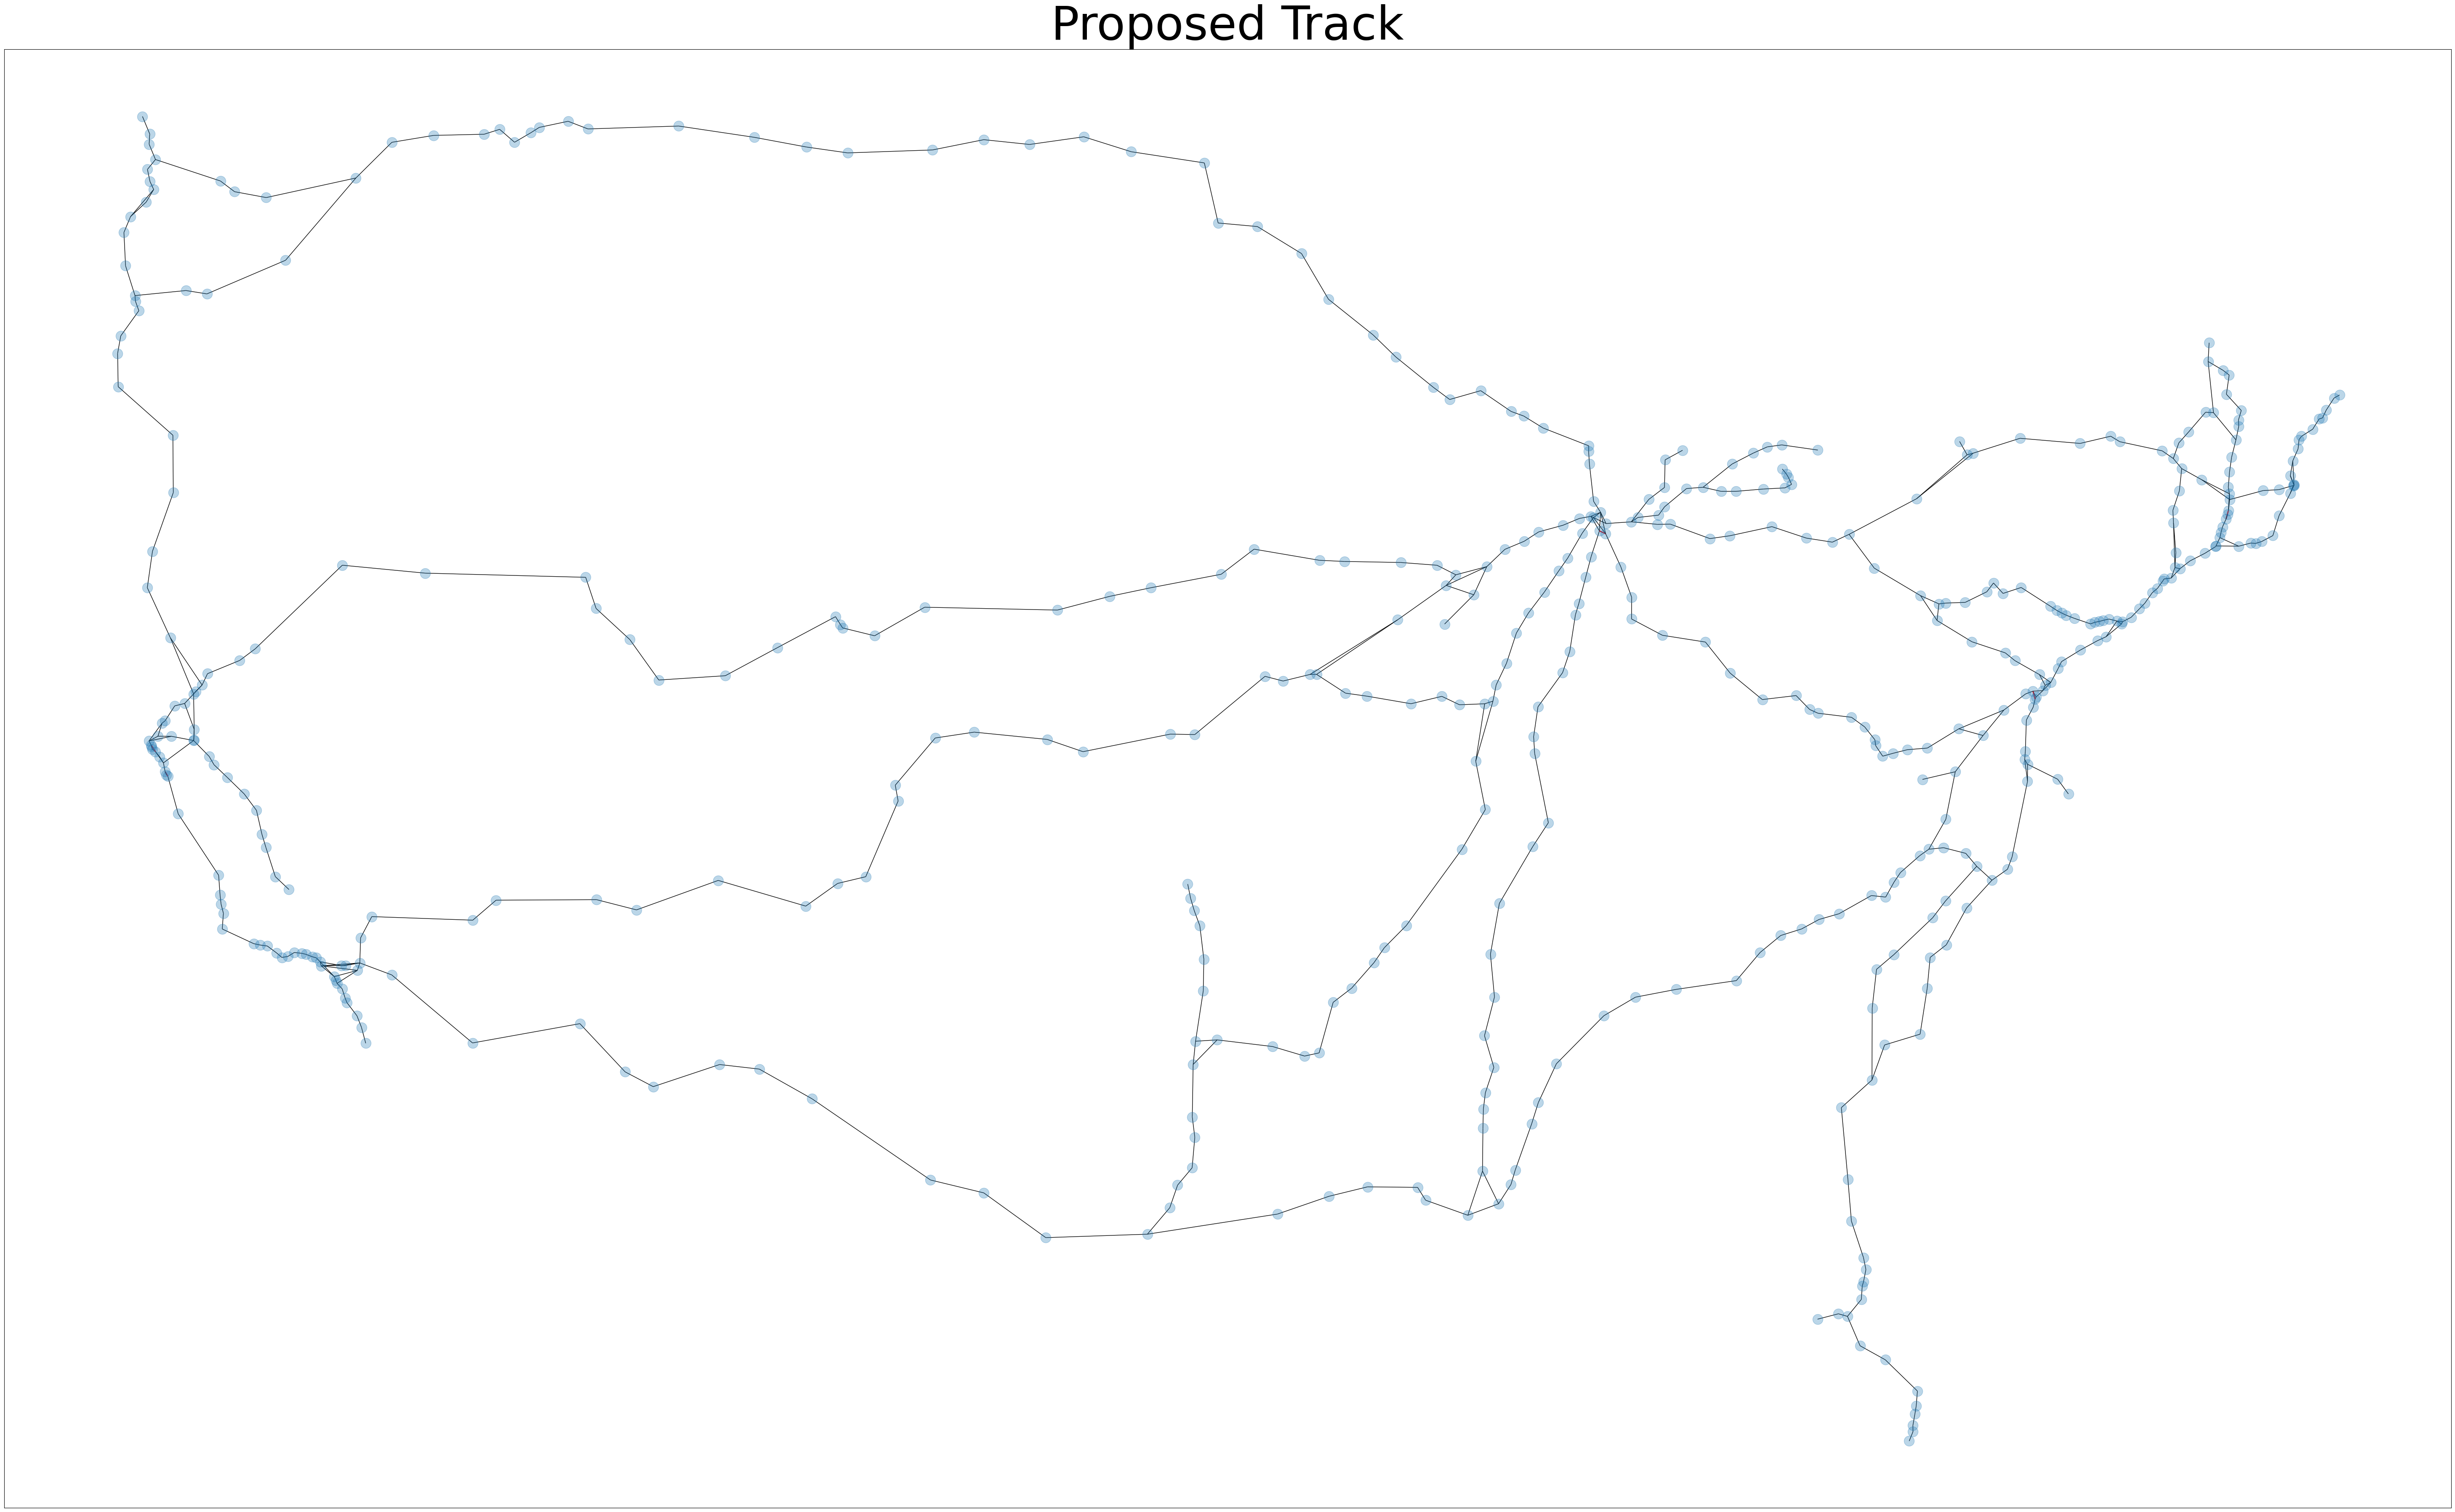

In [12]:
x = dict(nx.get_node_attributes(G, 'x'))
y = dict(nx.get_node_attributes(G, 'y'))

iter_df = pd.DataFrame(iterations0)

top_edges = iterations0['edges'][iter_df[iter_df['thresholds'] < 0.01]['lcc_scores'].idxmax()]
G2 = copy.deepcopy(G)
G2.add_edges_from(top_edges)
# Define positions, edge labels, and node labels
pos = {}
KM = nx.get_edge_attributes(G2, 'KM')
name = nx.get_node_attributes(G2, 'name')
KM = {i: round(KM[i], 2) for i in KM}
for i in G2.nodes:
    pos[i] = (x[i], y[i])
labels = {node: name[node] for node in G2.nodes}

# Draw the network with different edge colors
plt.figure(figsize=(75, 45))
for edge in G2.edges():
    if (edge[0], edge[1]) in top_edges or (edge[1], edge[0]) in top_edges:  # Check if the edge is the one you added
        nx.draw_networkx_edges(G2, pos, edgelist=[edge], edge_color='red', width=2.0)  # Set color to red for the added edge
    else:
        nx.draw_networkx_edges(G2, pos, edgelist=[edge], width=1.0)  # Use default color for other edges
nx.draw_networkx_nodes(G2, pos, alpha=0.3)
# nx.draw_networkx_labels(G2, pos, labels, font_size=12, font_color='black')
title = 'Proposed Track'
plt.title(title, fontsize = 80)
plt.savefig('../plots/new_track/presentation/ASP_5tracks_rider_alpha0_threshold01_lcc.png')
plt.show()
with open(r"../graphs/ASP_5tracks_rider_alpha0_threshold01_lcc.pickle", "wb") as output_file:
    cPickle.dump(G2, output_file)

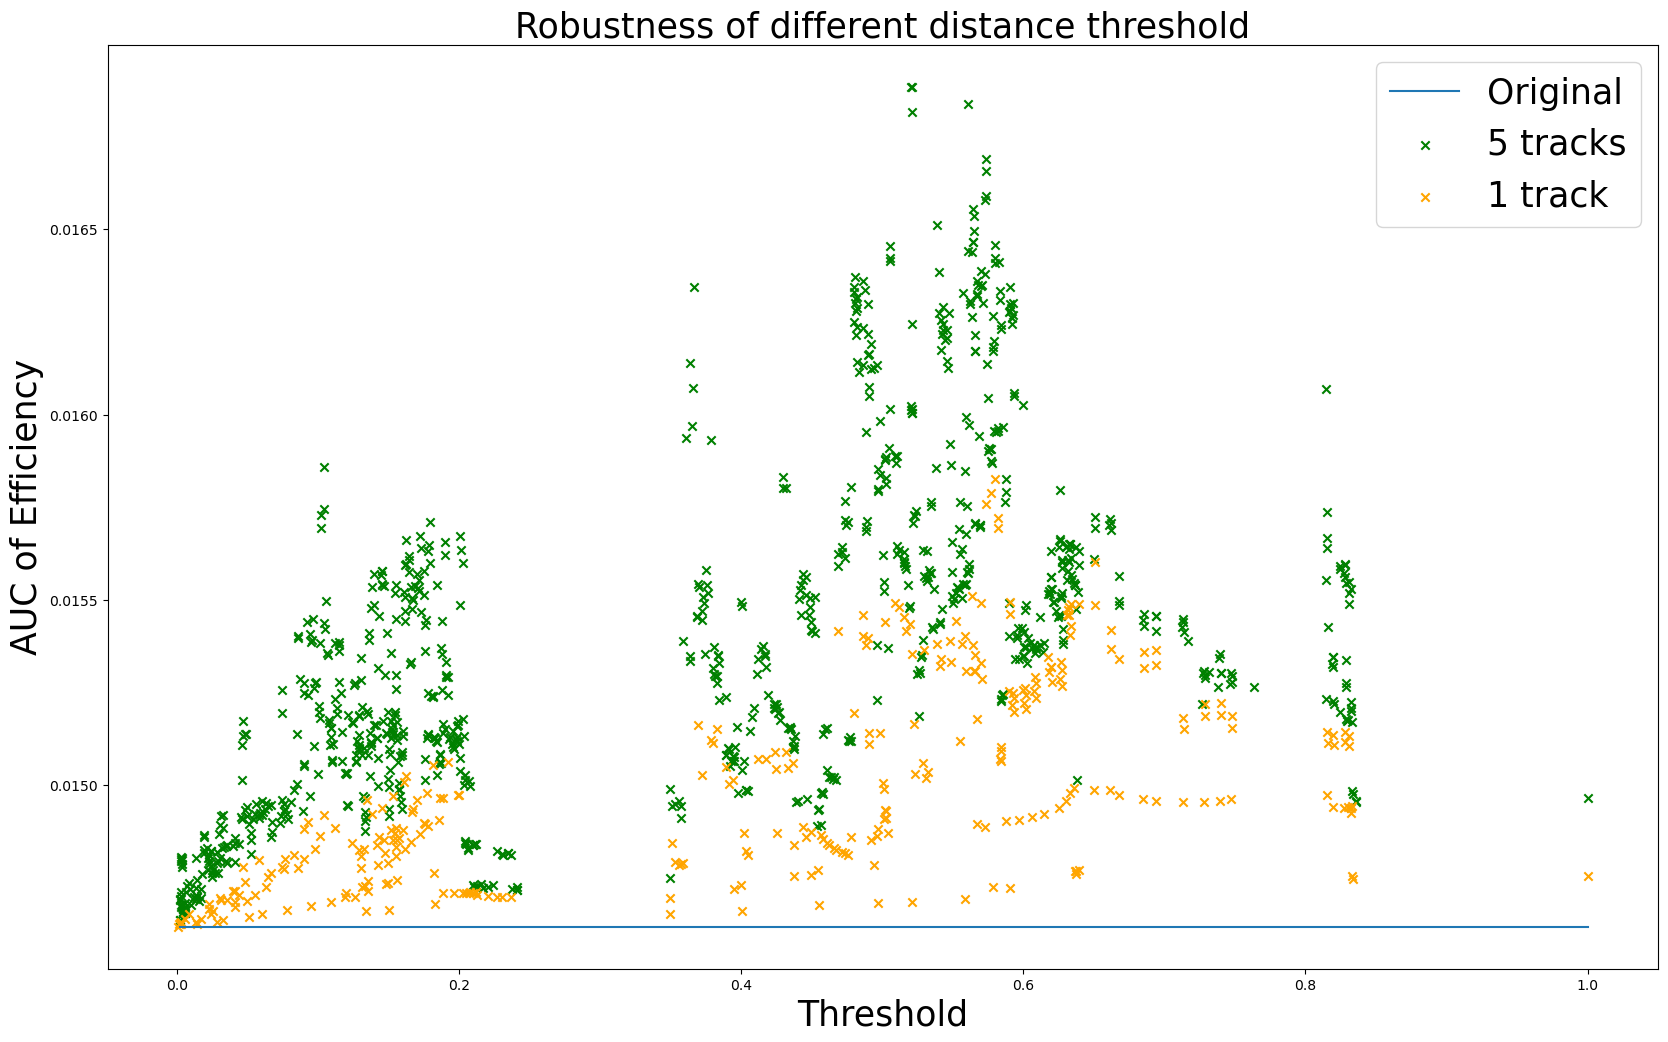

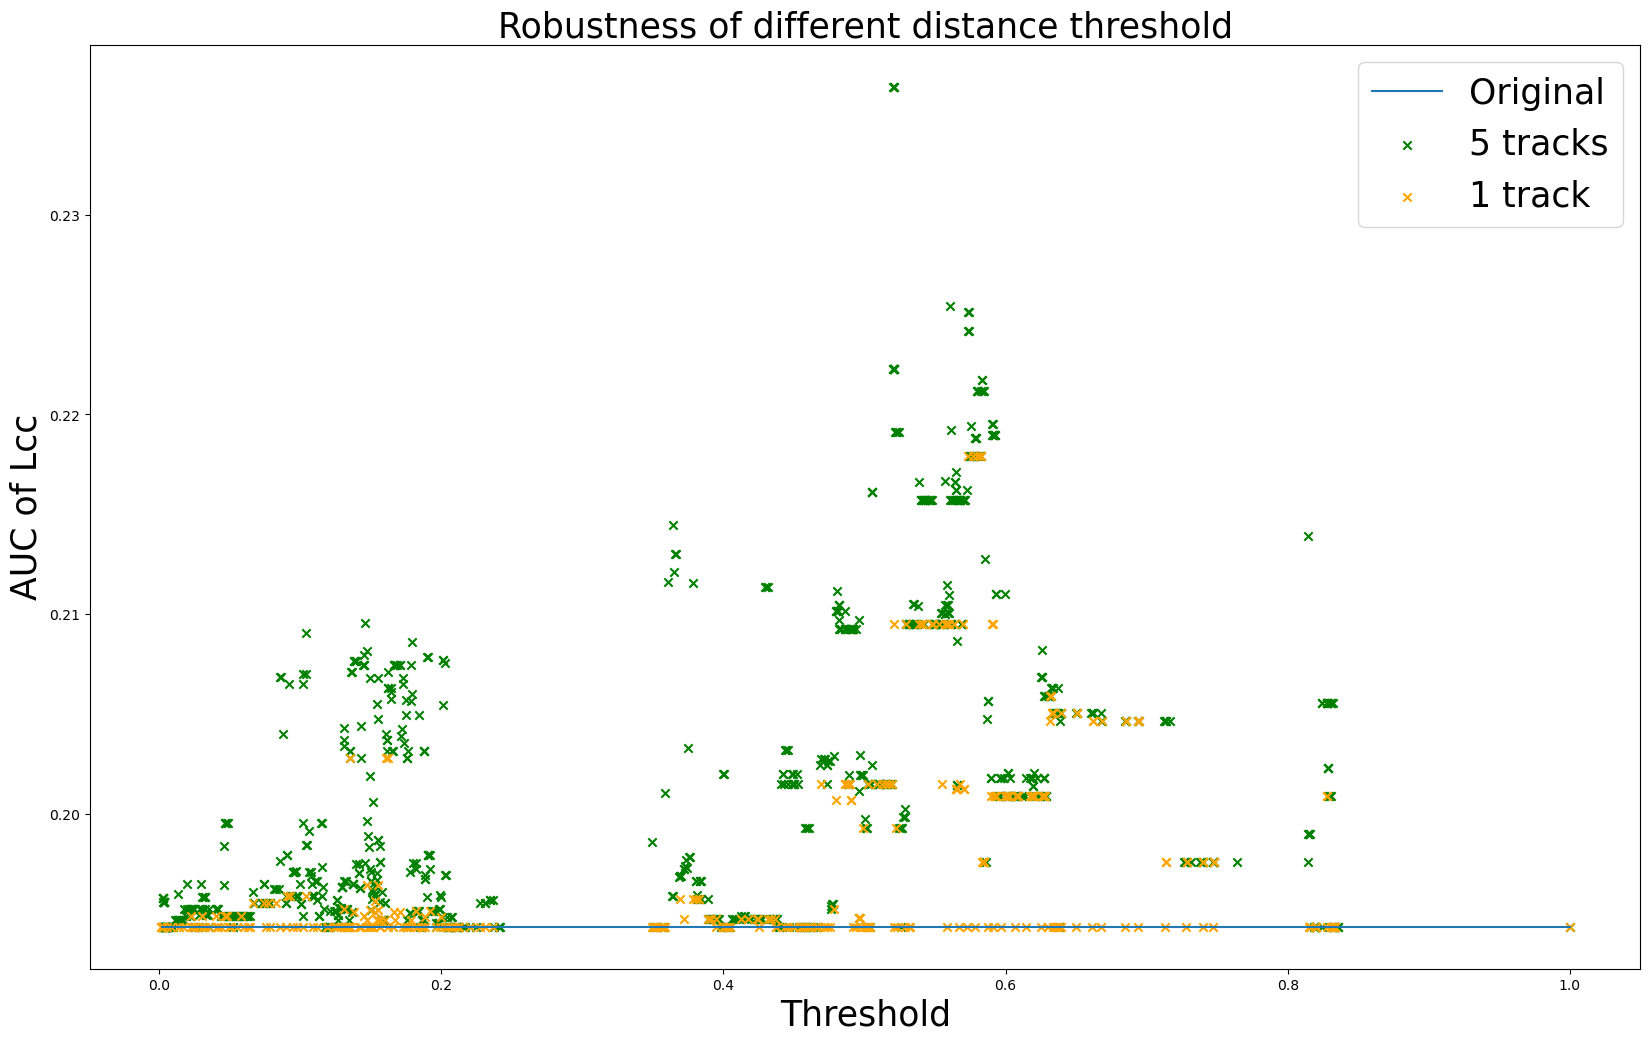

In [15]:
plt.figure(figsize=(20, 12))
with open(r"../files/iterations/ASP_5tracks_rider_0.pickle", "rb") as input_file:
    iterations0 = cPickle.load(input_file)
with open(r"../files/iterations/ASP_1tracks_rider_0.pickle", "rb") as input_file:
    iterations1 = cPickle.load(input_file)

e = robustness(G)
es = [e['Efficiency'] for _ in range(len(iterations0['thresholds']))]
plt.plot(iterations0['thresholds'], es,  label = 'Original')
# plt.plot(iterations5['thresholds'], iterations5["efficiency_scores"], marker='x', label = 'alpha = 5')
# plt.plot(iterations1['thresholds'], iterations1["efficiency_scores"], marker='x', label = 'alpha = 1')
# plt.plot(iterations05['thresholds'], iterations05["efficiency_scores"], marker='x', label = 'alpha = 0.5')
plt.scatter(iterations0['thresholds'], iterations0["efficiency_scores"], marker='x', label = '5 tracks', color = 'green')
plt.scatter(iterations1['thresholds'], iterations1["efficiency_scores"], marker='x', label = '1 track', color = 'orange')
plt.legend(loc = 'best',fontsize=25)
plt.xlabel('Threshold',fontsize=25)
plt.ylabel('AUC of Efficiency',fontsize=25)
plt.title('Robustness of different distance threshold',fontsize=25)
plt.savefig('../plots/robustness/efficiency_ASP_5c1tracks_rider_0.png')

plt.show()

plt.figure(figsize=(20, 12))

es = [e['Lcc'] for _ in range(len(iterations0['thresholds']))]
plt.plot(iterations0['thresholds'], es,  label = 'Original')
# plt.plot(iterations5['thresholds'], iterations5["lcc_scores"], marker='x', label = 'alpha = 5')
# plt.plot(iterations1['thresholds'], iterations1["lcc_scores"], marker='x', label = 'alpha = 1')
# plt.plot(iterations05['thresholds'], iterations05["lcc_scores"], marker='x', label = 'alpha = 0.5')
plt.scatter(iterations0['thresholds'], iterations0["lcc_scores"], marker='x', label = '5 tracks', color = 'green')
plt.scatter(iterations1['thresholds'], iterations1["lcc_scores"], marker='x', label = '1 track', color = 'orange')
plt.legend(loc = 'best',fontsize=25)
plt.xlabel('Threshold',fontsize=25)
plt.ylabel('AUC of Lcc',fontsize=25)
plt.title('Robustness of different distance threshold',fontsize=25)
plt.savefig('../plots/robustness/lcc_ASP_5c1tracks_rider_0.png')
plt.show()